In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##CALCULAR LA TRANSFORMADA DE FOURIER PARA MOVER LA MUESTRA DE 4HZ A 64HZ

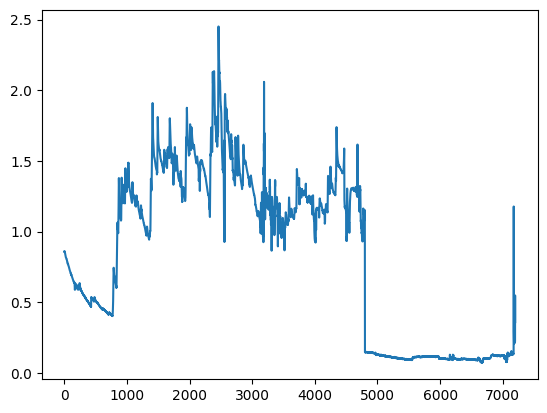

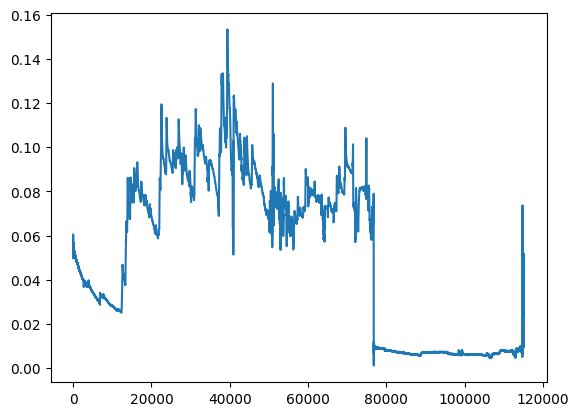

In [ ]:
import numpy as np
import locale
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pandas as pd
from scipy.signal import welch

# Señal de entrada
url = '/content/drive/MyDrive/TFG/WESAD/EDA-2.csv'
datos = pd.read_csv(url)
datos.head(3)
#cogemos la columna 0
signal = datos.iloc[:,0]


#indicar que el separadro decimal es el punto
locale.setlocale(locale.LC_NUMERIC, 'en_US.UTF-8')

# Limpiar los valores eliminando el carácter ';'
#signal = signal.str.replace(';', '')

# Convertir la columna a tipo float
signal_original = signal.astype(float).values


# Realizar la Transformada de Fourier Discreta (DFT)
fft_signal_original = np.fft.fft(signal_original)
sampling_rate_original=4

# Calcular la nueva longitud de la señal upsampled
sampling_rate_upsampled = 64  # Hz
upsampling_factor = sampling_rate_upsampled / sampling_rate_original
new_length = int(len(signal_original) * upsampling_factor)

# Interpolar los coeficientes de la DFT para aumentar la resolución en el dominio de la frecuencia
fft_signal_upsampled = np.zeros(new_length, dtype=complex)
fft_signal_upsampled[:len(fft_signal_original)//2] = fft_signal_original[:len(fft_signal_original)//2]
fft_signal_upsampled[-len(fft_signal_original)//2:] = fft_signal_original[-len(fft_signal_original)//2:]

# Aplicar la Transformada Inversa de Fourier Discreta (IDFT)
signal_upsampled = np.fft.ifft(fft_signal_upsampled)

# Tomar solo la parte real de la señal upsampled (los valores complejos pueden ser pequeñas aproximaciones numéricas)
signal_upsampled = np.real(signal_upsampled)

# La variable signal_upsampled ahora contiene la señal upsampled a 64 Hz
plt.plot(signal_original)
plt.show()
plt.plot(signal_upsampled)



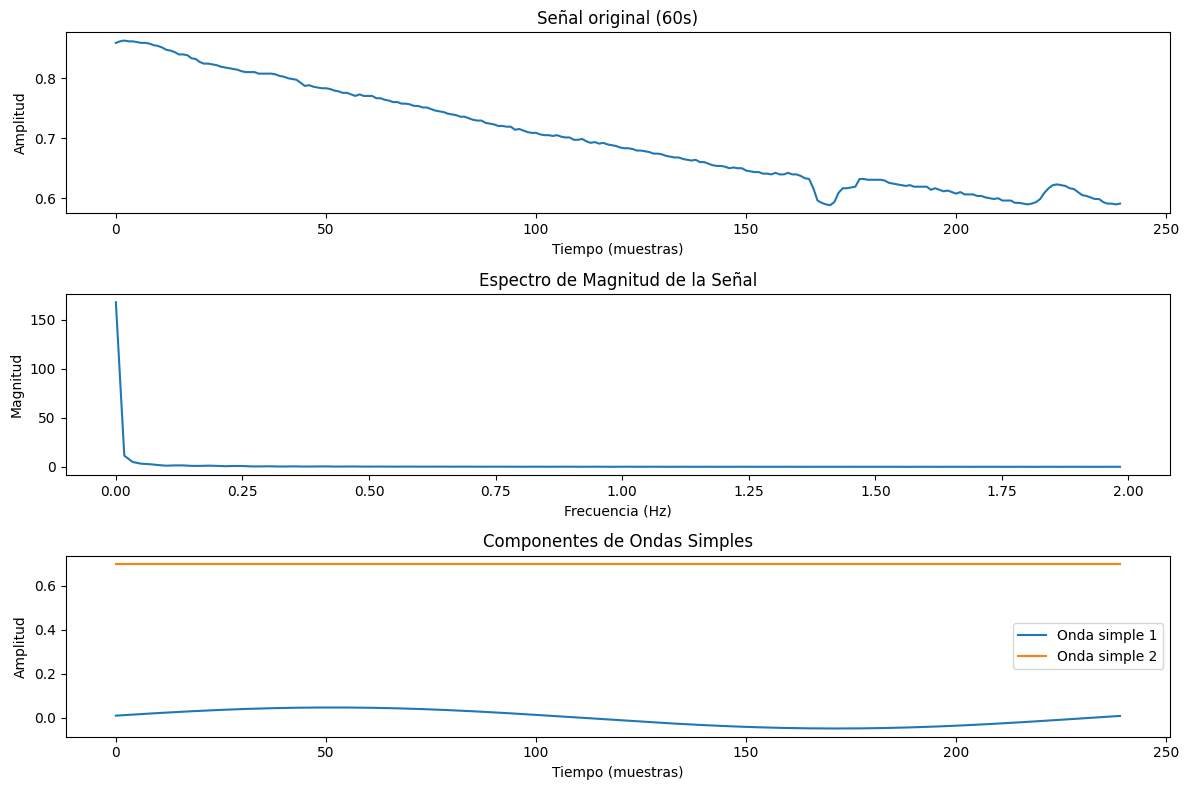

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, ifft



# Parámetros
sampling_rate = 4 # Frecuencia de muestreo en Hz
n = 240  # Número de puntos a analizar (60 segundos de datos)

# Extraer los primeros 3840 puntos de la señal
sampled_signal = signal_original[:n]

# Aplicar la Transformada de Fourier
fourier_transform = fft(sampled_signal)
frequencies = fftfreq(n, 1/sampling_rate)

# Magnitud del espectro
magnitude_spectrum = np.abs(fourier_transform)

# Descomponer en componentes de ondas simples
# Seleccionar algunas frecuencias dominantes
dominant_frequencies = np.argsort(magnitude_spectrum)[-2:]
components = [ifft(np.where(np.arange(n) == freq, fourier_transform, 0)) for freq in dominant_frequencies]

# Graficar la señal original
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(sampled_signal)
plt.title("Señal original (60s)")
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Amplitud")

# Graficar el espectro de magnitud
plt.subplot(3, 1, 2)
plt.plot(frequencies[:n//2], magnitude_spectrum[:n//2])  # Tomar solo la mitad positiva
plt.title("Espectro de Magnitud de la Señal")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")

# Graficar componentes de ondas simples
plt.subplot(3, 1, 3)
for i, component in enumerate(components, 1):
    plt.plot(component.real, label=f'Onda simple {i}')
plt.title("Componentes de Ondas Simples")
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Amplitud")
plt.legend()

plt.tight_layout()
plt.show()

##Añadimos los valores de estrés

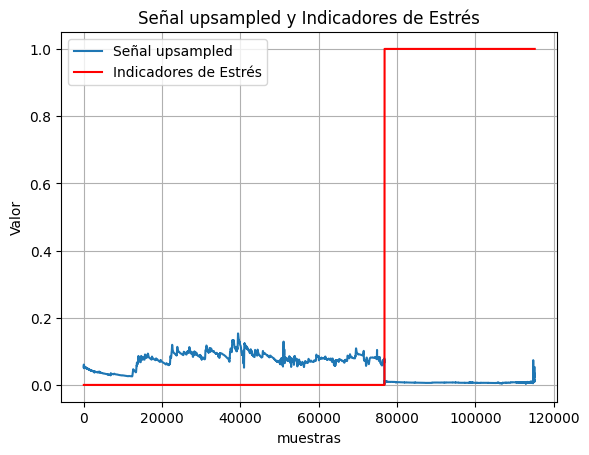

In [ ]:
# Crear una lista de valores de estrés
stress_labels = [0] * 76800 + [1] *(len(signal_upsampled) - 76800)

# Graficar la señal upsampled y los indicadores de estrés
plt.plot(signal_upsampled, label='Señal upsampled')
plt.plot(stress_labels, label='Indicadores de Estrés', color='red')
plt.xlabel('muestras')
plt.ylabel('Valor')
plt.title('Señal upsampled y Indicadores de Estrés')
plt.legend()
plt.grid(True)
plt.show()


      Señal  Estrés
0  0.053677       0
1  0.055477       0
2  0.057024       0
3  0.058297       0
4  0.059286       0


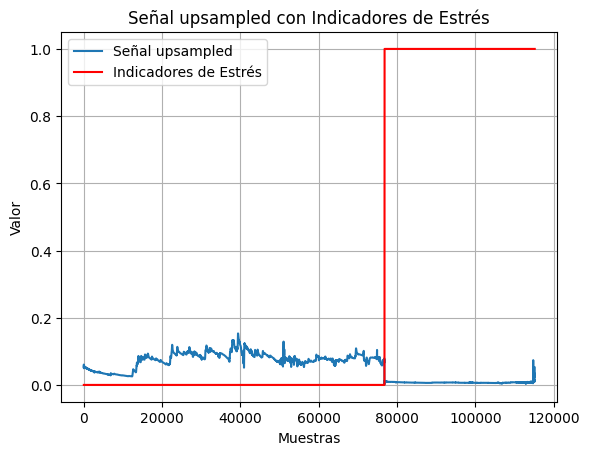

In [ ]:
# Asignar valores de estrés a la señal upsampled
signal_with_stress = {'Señal': signal_upsampled, 'Estrés': stress_labels}

# Convertir a DataFrame
df = pd.DataFrame(signal_with_stress)
print(df.head())

# Graficar la señal upsampled con los indicadores de estrés
plt.plot(df['Señal'], label='Señal upsampled')
plt.plot(df['Estrés'], label='Indicadores de Estrés', color='red')
plt.xlabel('Muestras')
plt.ylabel('Valor')
plt.title('Señal upsampled con Indicadores de Estrés')
plt.legend()
plt.grid(True)
plt.show()


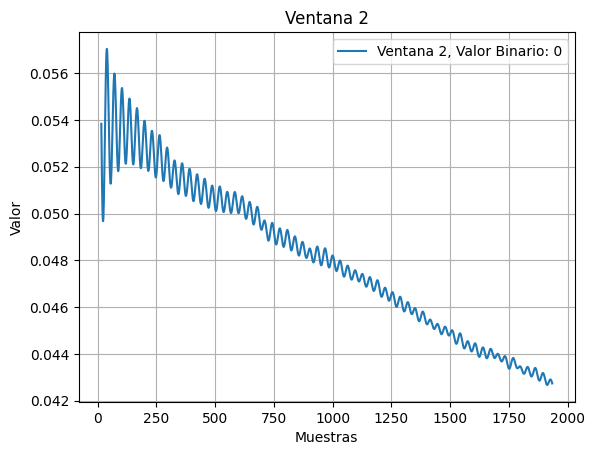

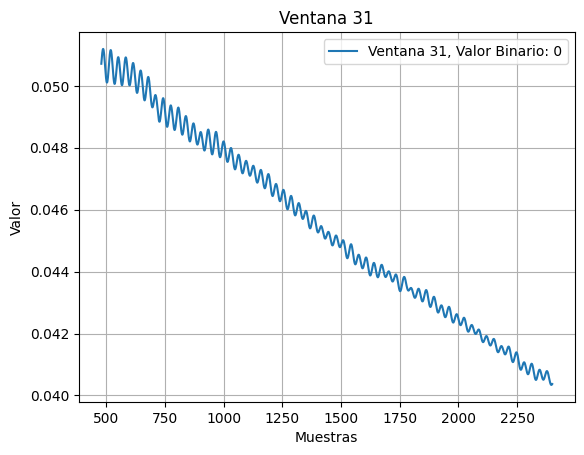

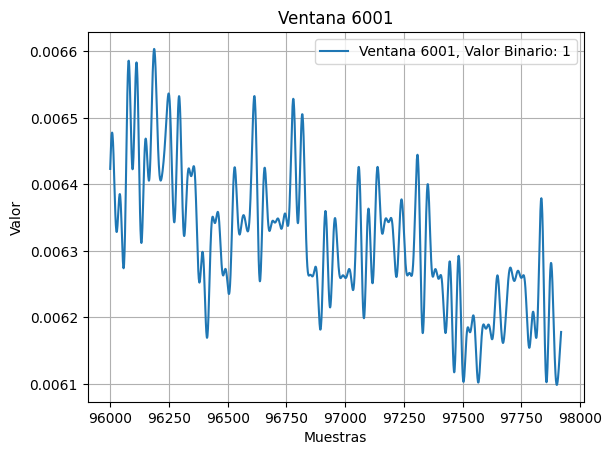

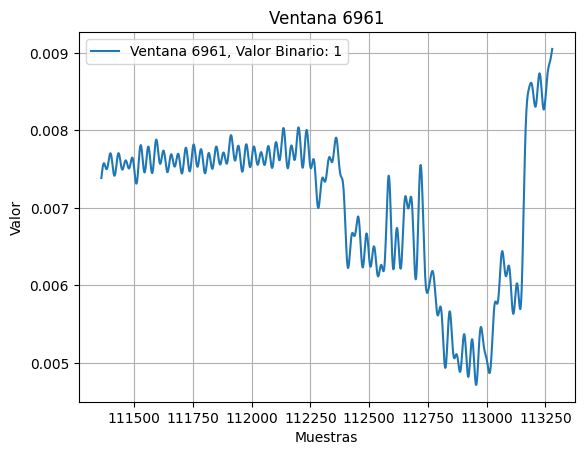

In [ ]:

# Segmentar los datos en ventanas de 30 segundos con un desplazamiento de 0.25 segundos
window_length_seconds = 30
sampling_rate = 64
overlap_seconds = 0.25
overlap_samples = int(overlap_seconds * sampling_rate)

# Calcular el número de muestras que contendrá la ventana
window_length_samples = window_length_seconds * sampling_rate

# Crear una lista para almacenar los valores binarios asociados a cada ventana
binary_values_windows = []
j=0

# Iterar sobre las ventanas
for i in range(0, len(df), overlap_samples):
    # Obtener los datos dentro de la ventana actual
    window_data = df.iloc[i:i+window_length_samples]

    # Contar los valores de estrés en la ventana actual
    stress_count_0 = window_data['Estrés'].value_counts().get(0, 0)
    stress_count_1 = window_data['Estrés'].value_counts().get(1, 0)

    # Determinar el valor binario asociado a la ventana actual
    binary_value = 0 if stress_count_0 > stress_count_1 else 1
    binary_values_windows.append(binary_value)

    if (j==1 or j==30 or j==6000 or j==6960):
      # Graficar la ventana actual
      plt.plot(window_data['Señal'], label=f'Ventana {i//overlap_samples + 1}, Valor Binario: {binary_value}')
      plt.xlabel('Muestras')
      plt.ylabel('Valor')
      plt.title(f'Ventana {i//overlap_samples + 1}')
      plt.legend()
      plt.grid(True)
      plt.show()
    j+=1




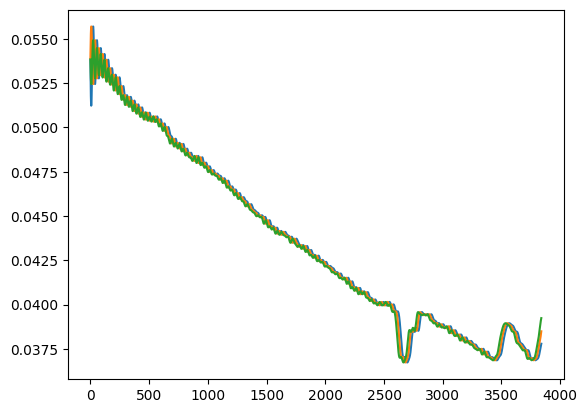

In [ ]:
#PASO1: CONVERTIR LOS DATOS EN UN ARRAY
eda_data= np.array(signal_upsampled)

#SEGMENTAR LOS DATOS EN VENTANAS DE 30S CON UN DESPLZAMIENTO DE 0.25

#Calculamos el número de datos que contendrá la ventana
window_length= 60 * 64
#lo mismo para el desplazamiento
overlap= int(0.25 * 64)
windows = [eda_data[i:i+window_length] for i in range(0, len(eda_data)-window_length+1, overlap)]
plt.plot(windows[1])
plt.plot(windows[2])
plt.plot(windows[3])


In [ ]:
import pandas as pd

# Crear una lista para almacenar los DataFrames de cada ventana
ventanas_df_list = []

# Iterar sobre las ventanas y agregar los datos a la lista
for i in range(len(binary_values_windows)):
    # Obtener los datos dentro de la ventana actual
    inicio_ventana = i * overlap_samples
    fin_ventana = inicio_ventana + window_length_samples
    ventana_data = df.iloc[inicio_ventana:fin_ventana]

    # Obtener el valor binario asociado a la ventana
    binario_ventana = binary_values_windows[i]

    # Crear un DataFrame para la ventana actual
    ventana_df = pd.DataFrame({'Ventana': [i+1], 'Valores': [ventana_data['Señal'].values], 'Estrés': [binario_ventana]})

    # Agregar el DataFrame de la ventana actual a la lista
    ventanas_df_list.append(ventana_df)

# Concatenar todos los DataFrames de las ventanas en uno solo
ventanas_df = pd.concat(ventanas_df_list, ignore_index=True)

# Mostrar el DataFrame resultante
ventanas_df.head()


,Ventana,Valores,Estrés
0,1,"[0.05367674999999999, 0.05547713384951329, 0.0...",0
1,2,"[0.053836874999999965, 0.05287319238536553, 0....",0
2,3,"[0.05391699999999997, 0.05460394776240906, 0.0...",0
3,4,"[0.053836875000000006, 0.05329095517361162, 0....",0
4,5,"[0.05383687500000004, 0.054288821317970054, 0....",0


##Creación del dataframe con los puntos espectrales

In [ ]:
import numpy as np
import locale
import matplotlib.pyplot as plt
from scipy.signal import welch
import pandas as pd

# Parámetros de muestreo
sampling_rate_original = 4
sampling_rate_upsampled = 64
upsampling_factor = sampling_rate_upsampled / sampling_rate_original

# Parámetros de las ventanas
window_length_s = 15
subwindow_length_s = 7
sampling_rate = 64
overlap_s = 0.1

# Calcular el número de muestras por ventana y el desplazamiento
window_samples = window_length_s * sampling_rate
subwindow_samples = subwindow_length_s * sampling_rate
overlap_samples = int(overlap_s * sampling_rate)

# Crear un DataFrame final para almacenar todos los resultados
final_df = pd.DataFrame()

# Rango de archivos que deseas procesar (por ejemplo, de EDA-2.csv a EDA-17.csv)
file_range = [2, 3, 4, 5, 6,7, 8, 9, 10,11, 13, 14,15, 16, 17]

# Iterar sobre el rango de archivos
for i in file_range:
    # Construir el nombre del archivo
    file_name = f'/content/drive/MyDrive/TFG/WESAD/EDA-{i}.csv'

    # Leer el archivo CSV
    datos = pd.read_csv(file_name)
    # Asumimos que cada archivo tiene una única columna con los datos de un sujeto
    signal = datos.iloc[:,0]
    print(f"Procesando sujeto: {i}")
    # Convertir la columna a tipo float
    #indicar que el separadro decimal es el punto
    locale.setlocale(locale.LC_NUMERIC, 'en_US.UTF-8')
    if i==9:
      signal = signal.str.replace(';', '')

    signal_original = signal.astype(float)

    # Realizar la Transformada de Fourier Discreta (DFT)
    fft_signal_original = np.fft.fft(signal_original)

    # Calcular la nueva longitud de la señal upsampled
    new_length = int(len(signal_original) * upsampling_factor)

    # Interpolar los coeficientes de la DFT para aumentar la resolución en el dominio de la frecuencia
    fft_signal_upsampled = np.zeros(new_length, dtype=complex)
    fft_signal_upsampled[:len(fft_signal_original)//2] = fft_signal_original[:len(fft_signal_original)//2]
    fft_signal_upsampled[-len(fft_signal_original)//2:] = fft_signal_original[-len(fft_signal_original)//2:]

    # Aplicar la Transformada Inversa de Fourier Discreta (IDFT)
    signal_upsampled = np.fft.ifft(fft_signal_upsampled)

    # Tomar solo la parte real de la señal upsampled
    signal_upsampled = np.real(signal_upsampled)
    stress_labels = [0] * 76800 + [1] * (len(signal_upsampled) - 76800)

    # Crear el DataFrame con la señal y el estrés
    signal_with_stress = {'Señal': signal_upsampled, 'Estrés': stress_labels}
    df = pd.DataFrame(signal_with_stress)

    # Listas para almacenar los valores espectrales promedio de cada ventana
    average_spectral_values = []
    stress_values = []
    window_numbers = []

    # Iterar sobre las ventanas
    for k in range(0, len(df), overlap_samples):
        # Obtener los datos de la ventana actual
        window_data = df.iloc[k:k+window_samples]

        # Lista para almacenar los espectros de las subventanas
        subwindow_spectra = []
        # Iterar sobre las subventanas dentro de la ventana actual
        for j in range(0, window_samples - subwindow_samples + 1, overlap_samples):
            if len(window_data.iloc[j:j+subwindow_samples]) < 448:
                continue

            # Obtener los datos de la subventana actual
            subwindow_data = window_data.iloc[j:j+subwindow_samples]

            # Calcular el espectro de frecuencias utilizando Welch para la subventana
            freqs, psd = welch(subwindow_data['Señal'], fs=sampling_rate)

            # Agregar el espectro de la subventana a la lista
            subwindow_spectra.append(psd)

        # Calcular el espectro promedio de todas las subventanas
        average_spectrum = np.mean(subwindow_spectra, axis=0)

        if np.isnan(average_spectrum).any():
            continue

        # Agregar el espectro promedio a la lista de valores espectrales promedio
        average_spectral_values.append(average_spectrum)

        # Obtener el valor de estrés de la ventana actual
        stress_value = window_data['Estrés'].iloc[0]  # Suponemos que el valor de estrés es el mismo para toda la ventana
        stress_values.append(stress_value)

        # Obtener el número de ventana
        window_number = int(k / overlap_samples) + 1
        window_numbers.append(window_number)

    # Convertir las listas a Series para poder agregarlas al DataFrame final
    stress_series = pd.Series(stress_values, name='Estrés')
    window_number_series = pd.Series(window_numbers, name='Número de ventana')

    # Convertir la lista de valores espectrales promedio a un DataFrame
    spectral_df = pd.DataFrame(average_spectral_values)

        # Concatenar el DataFrame de valores espectrales con las Series de estrés y número de ventana
    final_df = pd.concat([stress_series, window_number_series, spectral_df.astype(float)], axis=1)
        # Mostrar el DataFrame resultante
    print(final_df.head())
    final_df['id'] = i
    final_df.tail()

    # Guardar en el archivo CSV (crear archivo nuevo o append según sea necesario)
    if i == 2:
        final_df.to_csv('/content/drive/MyDrive/TFG/datos_archivoVENTANA15.csv', index=False)
    else:
        final_df.to_csv('/content/drive/MyDrive/TFG/datos_archivoVENTANA15.csv', mode='a', index=False, header=False)

    # Limpiar final_df para el siguiente sujeto
    final_df = pd.DataFrame()

# Mostrar el DataFrame resultante
print(final_df.head())


Procesando sujeto: 2


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


   Estrés  Número de ventana             0             1             2  \
0       0                  1  7.221849e-09  2.556200e-07  2.071355e-08   
1       0                  2  7.308785e-09  2.547228e-07  2.065049e-08   
2       0                  3  7.421257e-09  2.536029e-07  2.053963e-08   
3       0                  4  7.263576e-09  2.520773e-07  2.037682e-08   
4       0                  5  6.981156e-09  2.503755e-07  2.016874e-08   

              3             4             5             6             7  ...  \
0  4.326149e-09  2.173135e-09  2.113827e-09  2.046633e-09  1.581620e-07  ...   
1  4.304967e-09  2.204065e-09  2.096383e-09  1.984807e-09  1.525485e-07  ...   
2  4.301284e-09  2.232525e-09  2.082124e-09  1.936616e-09  1.472752e-07  ...   
3  4.317167e-09  2.256890e-09  2.070018e-09  1.898794e-09  1.423489e-07  ...   
4  4.348290e-09  2.277641e-09  2.057310e-09  1.864130e-09  1.377303e-07  ...   

            119           120           121           122           123  \

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


   Estrés  Número de ventana         0         1         2             3  \
0       0                  1  0.000003  0.000020  0.000003  2.294714e-07   
1       0                  2  0.000003  0.000020  0.000003  2.232743e-07   
2       0                  3  0.000003  0.000019  0.000003  2.173982e-07   
3       0                  4  0.000003  0.000019  0.000003  2.117360e-07   
4       0                  5  0.000003  0.000018  0.000003  2.062794e-07   

              4             5             6             7  ...           119  \
0  6.430267e-08  1.530218e-08  1.014454e-08  8.039294e-07  ...  6.031405e-19   
1  6.243845e-08  1.516208e-08  1.014342e-08  7.636193e-07  ...  5.491199e-19   
2  6.076444e-08  1.497593e-08  1.002175e-08  7.263113e-07  ...  5.465544e-19   
3  5.928923e-08  1.477329e-08  9.801717e-09  6.912644e-07  ...  5.385399e-19   
4  5.795771e-08  1.463715e-08  9.580240e-09  6.584704e-07  ...  5.174724e-19   

            120           121           122           123     

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


   Estrés  Número de ventana             0             1             2  \
0       0                  1  1.430285e-08  1.852748e-07  4.297553e-08   
1       0                  2  1.416449e-08  1.832521e-07  4.260418e-08   
2       0                  3  1.423257e-08  1.813150e-07  4.224965e-08   
3       0                  4  1.436555e-08  1.794321e-07  4.191824e-08   
4       0                  5  1.445236e-08  1.775810e-07  4.161239e-08   

              3             4             5             6             7  ...  \
0  1.134917e-08  9.183257e-09  4.596138e-09  7.355790e-09  1.259292e-08  ...   
1  1.147971e-08  9.214919e-09  4.680361e-09  7.423011e-09  1.206333e-08  ...   
2  1.161812e-08  9.253463e-09  4.775065e-09  7.522725e-09  1.166055e-08  ...   
3  1.175978e-08  9.299234e-09  4.879178e-09  7.652762e-09  1.138562e-08  ...   
4  1.190191e-08  9.348867e-09  4.991470e-09  7.807845e-09  1.122665e-08  ...   

            119           120           121           122           123  \

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


   Estrés  Número de ventana             0             1             2  \
0       0                  1  1.849952e-07  1.135131e-06  2.673922e-07   
1       0                  2  1.707383e-07  1.067549e-06  2.443959e-07   
2       0                  3  1.587215e-07  1.000326e-06  2.234602e-07   
3       0                  4  1.485716e-07  9.339910e-07  2.045126e-07   
4       0                  5  1.406474e-07  8.697001e-07  1.874444e-07   

              3             4             5             6             7  ...  \
0  4.898327e-08  1.007126e-07  9.846474e-08  1.045734e-07  7.652347e-08  ...   
1  4.812797e-08  8.781491e-08  8.121991e-08  8.741852e-08  7.037869e-08  ...   
2  4.771424e-08  7.663263e-08  6.687436e-08  7.233462e-08  6.482291e-08  ...   
3  4.748599e-08  6.703085e-08  5.533564e-08  5.940186e-08  5.978254e-08  ...   
4  4.720170e-08  5.891833e-08  4.635436e-08  4.859291e-08  5.521168e-08  ...   

            119           120           121           122           123  \

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


   Estrés  Número de ventana         0         1         2             3  \
0       0                  1  0.000002  0.000008  0.000002  8.741756e-07   
1       0                  2  0.000001  0.000008  0.000002  8.351398e-07   
2       0                  3  0.000001  0.000008  0.000002  7.924717e-07   
3       0                  4  0.000001  0.000007  0.000002  7.461837e-07   
4       0                  5  0.000001  0.000007  0.000002  6.969462e-07   

              4             5             6             7  ...           119  \
0  3.881364e-07  1.578763e-07  1.323867e-07  3.432029e-07  ...  1.612385e-19   
1  3.729930e-07  1.547123e-07  1.281790e-07  3.198999e-07  ...  1.392573e-19   
2  3.579094e-07  1.513303e-07  1.236788e-07  2.957256e-07  ...  1.129016e-19   
3  3.428315e-07  1.473005e-07  1.186178e-07  2.715543e-07  ...  9.525330e-20   
4  3.273559e-07  1.422522e-07  1.129344e-07  2.477881e-07  ...  9.116591e-20   

            120           121           122           123     

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


   Estrés  Número de ventana         0         1         2         3  \
0       0                  1  0.000019  0.000104  0.000048  0.000012   
1       0                  2  0.000019  0.000105  0.000048  0.000011   
2       0                  3  0.000020  0.000107  0.000048  0.000011   
3       0                  4  0.000020  0.000108  0.000048  0.000011   
4       0                  5  0.000021  0.000109  0.000048  0.000010   

          4         5             6         7  ...           119  \
0  0.000008  0.000003  9.154757e-07  0.000002  ...  1.279443e-18   
1  0.000008  0.000003  9.018227e-07  0.000002  ...  1.255207e-18   
2  0.000008  0.000003  8.962091e-07  0.000002  ...  1.261892e-18   
3  0.000008  0.000003  8.980314e-07  0.000002  ...  1.273368e-18   
4  0.000008  0.000003  9.069952e-07  0.000002  ...  1.291261e-18   

            120           121           122           123           124  \
0  1.022104e-18  7.979322e-19  6.058201e-19  4.448235e-19  3.141547e-19   
1  9.952

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


   Estrés  Número de ventana         0         1         2             3  \
0       0                  1  0.000008  0.000039  0.000007  5.887002e-07   
1       0                  2  0.000008  0.000039  0.000007  5.884839e-07   
2       0                  3  0.000008  0.000039  0.000007  5.899134e-07   
3       0                  4  0.000008  0.000039  0.000007  5.928607e-07   
4       0                  5  0.000007  0.000039  0.000007  5.970080e-07   

              4             5             6             7  ...           119  \
0  3.067928e-07  4.966976e-07  3.304483e-07  3.715313e-07  ...  5.519455e-19   
1  3.177015e-07  5.086963e-07  3.315853e-07  3.700275e-07  ...  5.446902e-19   
2  3.293874e-07  5.197065e-07  3.326813e-07  3.694886e-07  ...  5.386787e-19   
3  3.417063e-07  5.298532e-07  3.339882e-07  3.701509e-07  ...  5.357275e-19   
4  3.543333e-07  5.393855e-07  3.357274e-07  3.719860e-07  ...  5.383271e-19   

            120           121           122           123     

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


   Estrés  Número de ventana             0         1         2             3  \
0       0                  1  3.216247e-07  0.000002  0.000001  2.811464e-07   
1       0                  2  3.258867e-07  0.000002  0.000001  2.932488e-07   
2       0                  3  3.320678e-07  0.000002  0.000001  3.041014e-07   
3       0                  4  3.418533e-07  0.000003  0.000001  3.134598e-07   
4       0                  5  3.552843e-07  0.000003  0.000001  3.212604e-07   

              4             5             6             7  ...           119  \
0  1.453865e-07  1.094885e-07  4.812946e-08  1.528407e-07  ...  1.188606e-19   
1  1.537651e-07  1.165425e-07  5.001381e-08  1.619413e-07  ...  1.113419e-19   
2  1.623273e-07  1.244227e-07  5.225540e-08  1.719708e-07  ...  1.006963e-19   
3  1.711531e-07  1.332873e-07  5.511881e-08  1.829348e-07  ...  9.277881e-20   
4  1.802761e-07  1.433348e-07  5.889465e-08  1.946523e-07  ...  9.006547e-20   

            120           121         

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


   Estrés  Número de ventana             0             1             2  \
0       0                  1  1.150379e-08  6.308086e-08  4.904020e-08   
1       0                  2  1.140388e-08  6.256892e-08  4.776827e-08   
2       0                  3  1.128932e-08  6.228788e-08  4.661252e-08   
3       0                  4  1.114776e-08  6.216165e-08  4.555375e-08   
4       0                  5  1.098836e-08  6.210701e-08  4.456607e-08   

              3             4             5             6             7  ...  \
0  1.671719e-08  9.942448e-09  5.580406e-09  5.888702e-09  1.163984e-08  ...   
1  1.625124e-08  9.808372e-09  5.500644e-09  5.857750e-09  1.145569e-08  ...   
2  1.582462e-08  9.676744e-09  5.427126e-09  5.830147e-09  1.128140e-08  ...   
3  1.543854e-08  9.551689e-09  5.359945e-09  5.805004e-09  1.111743e-08  ...   
4  1.509217e-08  9.437012e-09  5.299246e-09  5.780511e-09  1.096272e-08  ...   

            119           120           121           122           123  \

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


   Estrés  Número de ventana             0         1         2         3  \
0       0                  1  8.543848e-07  0.000008  0.000005  0.000003   
1       0                  2  8.558263e-07  0.000008  0.000004  0.000003   
2       0                  3  8.571183e-07  0.000008  0.000004  0.000003   
3       0                  4  8.582344e-07  0.000007  0.000004  0.000003   
4       0                  5  8.598640e-07  0.000007  0.000004  0.000003   

          4         5         6         7  ...           119           120  \
0  0.000002  0.000003  0.000001  0.000002  ...  3.196625e-19  2.541460e-19   
1  0.000002  0.000003  0.000001  0.000002  ...  3.043516e-19  2.415820e-19   
2  0.000002  0.000003  0.000001  0.000002  ...  2.909223e-19  2.309251e-19   
3  0.000002  0.000003  0.000001  0.000002  ...  2.828137e-19  2.244594e-19   
4  0.000002  0.000003  0.000001  0.000002  ...  2.796456e-19  2.218670e-19   

            121           122           123           124           125  \

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


   Estrés  Número de ventana         0         1         2         3  \
0       0                  1  0.000007  0.000097  0.000016  0.000003   
1       0                  2  0.000007  0.000096  0.000016  0.000003   
2       0                  3  0.000008  0.000096  0.000016  0.000003   
3       0                  4  0.000008  0.000096  0.000016  0.000003   
4       0                  5  0.000008  0.000096  0.000016  0.000003   

              4             5             6             7  ...           119  \
0  3.973428e-07  3.657804e-07  3.234101e-07  4.044316e-07  ...  5.115822e-18   
1  3.977622e-07  3.638769e-07  3.236658e-07  4.007016e-07  ...  5.074046e-18   
2  3.976255e-07  3.615502e-07  3.238338e-07  3.972705e-07  ...  5.030089e-18   
3  3.964123e-07  3.593018e-07  3.237156e-07  3.940483e-07  ...  4.987720e-18   
4  3.937702e-07  3.575247e-07  3.231937e-07  3.907066e-07  ...  4.945360e-18   

            120           121           122           123           124  \
0  4.016376

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


   Estrés  Número de ventana             0             1             2  \
0       0                  1  2.042004e-09  1.399975e-08  7.588357e-09   
1       0                  2  2.076730e-09  1.409763e-08  7.445539e-09   
2       0                  3  2.115728e-09  1.417122e-08  7.296390e-09   
3       0                  4  2.155460e-09  1.421948e-08  7.138991e-09   
4       0                  5  2.192506e-09  1.424421e-08  6.972340e-09   

              3             4             5             6             7  ...  \
0  5.066590e-09  3.341039e-09  3.191701e-09  2.225773e-09  2.960207e-09  ...   
1  5.026819e-09  3.297826e-09  3.140120e-09  2.195678e-09  2.996798e-09  ...   
2  4.984222e-09  3.260604e-09  3.093801e-09  2.167443e-09  3.030734e-09  ...   
3  4.935357e-09  3.226201e-09  3.050930e-09  2.141060e-09  3.061895e-09  ...   
4  4.877788e-09  3.191042e-09  3.009914e-09  2.116596e-09  3.090128e-09  ...   

            119           120           121           122           123  \

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


   Estrés  Número de ventana             0             1             2  \
0       0                  1  8.231955e-08  4.570520e-07  1.716288e-07   
1       0                  2  9.289806e-08  4.691123e-07  1.751379e-07   
2       0                  3  1.045702e-07  4.846635e-07  1.798443e-07   
3       0                  4  1.160215e-07  5.038321e-07  1.862583e-07   
4       0                  5  1.263245e-07  5.268032e-07  1.949548e-07   

              3             4             5             6             7  ...  \
0  7.267448e-08  4.697902e-08  2.265293e-08  2.591654e-08  3.947174e-08  ...   
1  7.274224e-08  4.781879e-08  2.306791e-08  2.588203e-08  4.012777e-08  ...   
2  7.252630e-08  4.883715e-08  2.368446e-08  2.584337e-08  4.072069e-08  ...   
3  7.211951e-08  5.015630e-08  2.449753e-08  2.580641e-08  4.126055e-08  ...   
4  7.171038e-08  5.189429e-08  2.549726e-08  2.576908e-08  4.176950e-08  ...   

            119           120           121           122           123  \

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


   Estrés  Número de ventana             0             1             2  \
0       0                  1  8.704531e-10  6.316004e-09  4.284598e-09   
1       0                  2  8.764813e-10  6.305051e-09  4.269392e-09   
2       0                  3  8.803920e-10  6.285332e-09  4.248799e-09   
3       0                  4  8.810502e-10  6.259230e-09  4.224624e-09   
4       0                  5  8.794431e-10  6.232321e-09  4.198606e-09   

              3             4             5             6             7  ...  \
0  2.468115e-09  4.008066e-09  7.841937e-09  1.185280e-08  5.362301e-09  ...   
1  2.492395e-09  4.053386e-09  7.878475e-09  1.182629e-08  5.377707e-09  ...   
2  2.511267e-09  4.093572e-09  7.906934e-09  1.178680e-08  5.388523e-09  ...   
3  2.522905e-09  4.126820e-09  7.927385e-09  1.173445e-08  5.395104e-09  ...   
4  2.526561e-09  4.151618e-09  7.939351e-09  1.166978e-08  5.397908e-09  ...   

            119           120           121           122           123  \

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


   Estrés  Número de ventana         0         1         2         3  \
0       0                  1  0.000043  0.000215  0.000090  0.000036   
1       0                  2  0.000044  0.000221  0.000093  0.000037   
2       0                  3  0.000044  0.000229  0.000096  0.000038   
3       0                  4  0.000045  0.000236  0.000100  0.000039   
4       0                  5  0.000045  0.000244  0.000103  0.000039   

          4         5         6         7  ...           119           120  \
0  0.000010  0.000005  0.000004  0.000005  ...  5.306601e-18  4.195875e-18   
1  0.000010  0.000006  0.000004  0.000005  ...  5.150213e-18  4.059159e-18   
2  0.000010  0.000006  0.000004  0.000005  ...  5.155403e-18  4.063346e-18   
3  0.000010  0.000006  0.000004  0.000005  ...  5.129108e-18  4.040907e-18   
4  0.000011  0.000006  0.000004  0.000005  ...  5.038855e-18  3.969185e-18   

            121           122           123           124           125  \
0  3.228259e-18  2.3989

In [ ]:
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/TFG/datos_archivoVENTANA15.csv')
data.tail()

,Estrés,Número de ventana,0,1,2,3,4,5,6,7,...,120,121,122,123,124,125,126,127,128,id
287480,1,19119,1.337193e-08,7.323108e-09,3.458151e-09,6.590254e-09,3.025684e-09,4.323772e-09,2.422500e-08,0.000003,...,1.343925e-19,1.156514e-19,9.960024e-20,8.615579e-20,7.524865e-20,6.682273e-20,6.083480e-20,5.725423e-20,2.803137e-20,17
287481,1,19120,1.395313e-08,7.863276e-09,3.363209e-09,7.010655e-09,2.637057e-09,4.508193e-09,2.387759e-08,0.000003,...,1.429791e-19,1.225143e-19,1.049868e-19,9.030589e-20,7.839561e-20,6.919474e-20,6.265610e-20,5.874623e-20,2.872258e-20,17
287482,1,19121,1.765138e-08,9.556976e-09,3.228641e-09,7.406741e-09,2.308662e-09,4.771205e-09,2.314331e-08,0.000003,...,1.549889e-19,1.355486e-19,1.188995e-19,1.049550e-19,9.364255e-20,8.490383e-20,7.869377e-20,7.498043e-20,3.687239e-20,17
287483,1,19122,1.210490e-08,5.672851e-09,3.043867e-09,7.713892e-09,2.101386e-09,5.087781e-09,2.202080e-08,0.000003,...,1.680892e-19,1.401236e-19,1.161706e-19,9.610664e-20,7.982864e-20,6.725325e-20,5.831628e-20,5.297221e-20,2.559693e-20,17
287484,1,19123,1.763486e-08,5.248559e-09,2.858120e-09,7.919208e-09,2.064988e-09,5.448121e-09,2.075628e-08,0.000003,...,1.731257e-19,1.480344e-19,1.265458e-19,1.085477e-19,9.394699e-20,8.266805e-20,7.465280e-20,6.986006e-20,3.413260e-20,17


##Para el dataset de AMIGOS

#Obtenemos los datos del '.mat'

In [ ]:
import scipy.io
import pandas as pd
import numpy as np
mat= scipy.io.loadmat('/content/drive/MyDrive/TFG/AMIGOS/Data_Original_P09.mat')
data=mat['GSR_DATA']#me devuelve las 20 matrices de cada uno de los videos


In [ ]:
# Asignar las variables directamente desde data
video1 = data[0][0]
video2 = data[0][1]
video3 = data[0][2]
video4 = data[0][3]
video5 = data[0][4]
video6 = data[0][5]
video7 = data[0][6]
video8 = data[0][7]
video9 = data[0][8]
video10 = data[0][9]
video11 = data[0][10]
video12 = data[0][11]
video13 = data[0][12]
video14 = data[0][13]
video15 = data[0][14]
video16 = data[0][15]

In [ ]:
#signal = np.concatenate((video1[:, 1], video2[:, 1], video3[:,1], video4[:,1],video5[:,1],video6[:,1]))
import numpy as np


# Concatenar los datos de EDA de los videos del 1 al 16
signal = np.concatenate((video1[:, 1], video2[:, 1], video3[:, 1], video4[:, 1], video5[:, 1], video6[:, 1],
                         video7[:, 1], video8[:, 1], video9[:, 1], video10[:, 1], video11[:, 1], video12[:, 1],
                         video13[:, 1], video14[:, 1], video15[:, 1], video16[:, 1]))

In [ ]:
#!pip install neurokit2
#!pip install pyts

#Limpieza de la señal

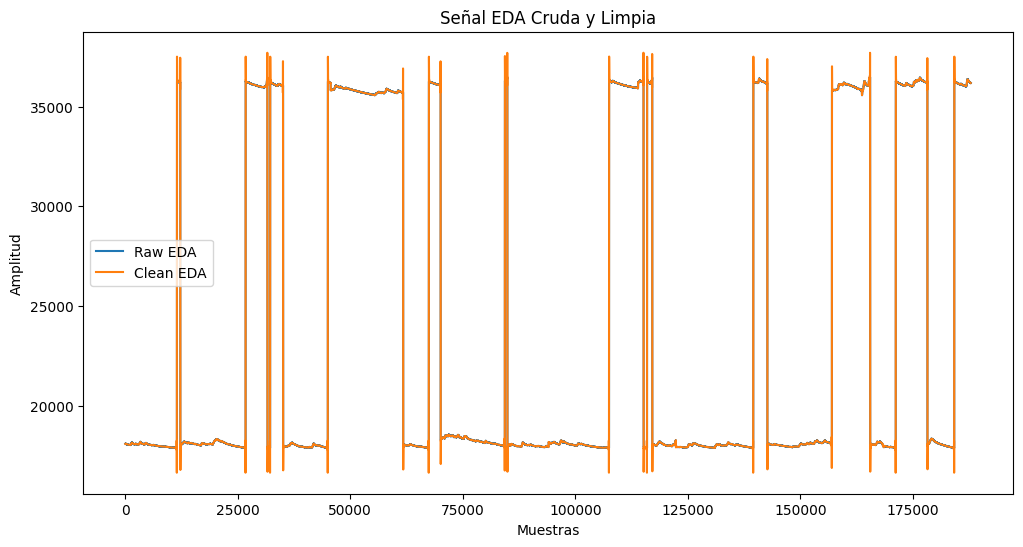

In [ ]:
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pandas as pd
signals, info = nk.eda_process(signal, sampling_rate=128)
#Gráfica de la señal EDA cruda y limpia
plt.figure(figsize=(12, 6))
plt.plot(signals["EDA_Raw"], label="Raw EDA")
plt.plot(signals["EDA_Clean"], label="Clean EDA")
plt.title("Señal EDA Cruda y Limpia")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend()
plt.show()


#Dividimos en 2 clases el estrés

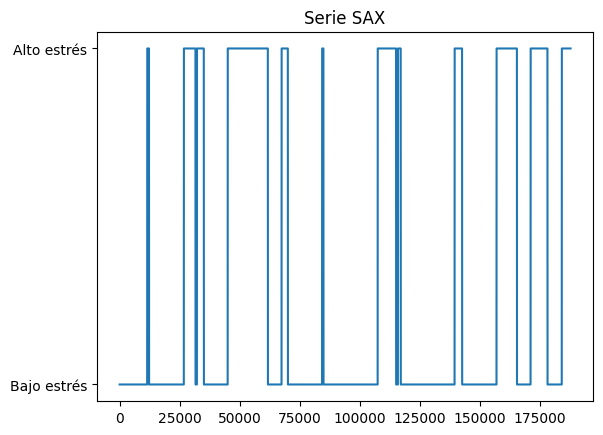

In [ ]:
from pyts.approximation import SymbolicAggregateApproximation
import matplotlib.pyplot as plt

# Suponiendo que 'normalizados' contiene la señal normalizada

# Se discretiza la señal normalizada en 2 niveles de estrés.
niveles = 2

# Se aplica SAX directamente a la señal normalizada
sax = SymbolicAggregateApproximation(n_bins=niveles, strategy='uniform')
serie_sax = sax.fit_transform(signals["EDA_Clean"].values.reshape(1, -1))

# Visualizar la serie SAX
fig, ax = plt.subplots()
ax.plot(serie_sax[0])
ax.set_yticks([0, 1])
ax.set_yticklabels(['Bajo estrés', 'Alto estrés'])  # Cambia las etiquetas según tus necesidades
ax.set_title('Serie SAX')
plt.show()

In [ ]:
import pandas as pd
from pyts.approximation import SymbolicAggregateApproximation

# Suponiendo que tienes una serie llamada 'signals' que contiene los datos de EDA clean en una sola columna

# Discretizar la señal EDA usando SAX
niveles = 2
sax = SymbolicAggregateApproximation(n_bins=niveles, strategy='uniform')
serie_sax = sax.fit_transform(signals["EDA_Clean"].values.reshape(1, -1))[0]

# Asignar la categoría de estrés (0 o 1)
categorias_estres = [0 if valor == 'a' else 1 for valor in serie_sax]

# Crear un DataFrame con los datos EDA clean y la columna de estrés
data = pd.DataFrame({'Señal': signals["EDA_Clean"], 'Estrés': categorias_estres})

# Calcular si hay más 0 o 1 en cada fila
data['Estrés'] = (data['Estrés'] == 0).astype(int)


print(data.head())
#print(data.tail())
#agregacion.to_csv('EDA_AMIGOSCNN.csv', index=False)

          Señal  Estrés
0  18071.748866       1
1  18072.003358       1
2  18072.263851       1
3  18072.530350       1
4  18072.802860       1


##Creación del dataframe con las ventanas y subventanas

In [ ]:
import scipy.io
import pandas as pd
import numpy as np
import pandas as pd
from pyts.approximation import SymbolicAggregateApproximation
import neurokit2 as nk
from scipy.signal import welch

sujetos= [12,13,14,15]#falta el 9
for sujeto in sujetos:
  print('procesando sujeto ', sujeto)
  file_name = f'/content/drive/MyDrive/TFG/AMIGOS/Data_Original_P{sujeto}.mat'
  mat= scipy.io.loadmat(file_name)
  data=mat['GSR_DATA']#me devuelve las 20 matrices de cada uno de los videos
  # Asignar las variables directamente desde data
  video1 = data[0][0]
  video2 = data[0][1]
  video3 = data[0][2]
  video4 = data[0][3]
  video5 = data[0][4]
  video6 = data[0][5]
  video7 = data[0][6]
  video8 = data[0][7]
  video9 = data[0][8]
  video10 = data[0][9]
  video11 = data[0][10]
  video12 = data[0][11]
  video13 = data[0][12]
  video14 = data[0][13]
  video15 = data[0][14]
  video16 = data[0][15]

  # Concatenar los datos de EDA de los videos del 1 al 16
  signal = np.concatenate((video1[:, 1], video2[:, 1], video3[:, 1], video4[:, 1], video5[:, 1], video6[:, 1],
                         video7[:, 1], video8[:, 1], video9[:, 1], video10[:, 1], video11[:, 1], video12[:, 1],
                         video13[:, 1], video14[:, 1], video15[:, 1], video16[:, 1]))

# Suponiendo que tienes una serie llamada 'signals' que contiene los datos de EDA clean en una sola columna

# Discretizar la señal EDA usando SAX
  signals, info = nk.eda_process(signal, sampling_rate=128)
  niveles = 2
  sax = SymbolicAggregateApproximation(n_bins=niveles, strategy='uniform')
  serie_sax = sax.fit_transform(signals["EDA_Clean"].values.reshape(1, -1))[0]

# Asignar la categoría de estrés (0 o 1)
  categorias_estres = [0 if valor == 'a' else 1 for valor in serie_sax]

# Crear un DataFrame con los datos EDA clean y la columna de estrés
  data = pd.DataFrame({'Señal': signals["EDA_Clean"], 'Estrés': categorias_estres})

# Calcular si hay más 0 o 1 en cada fila
  data['Estrés'] = (data['Estrés'] == 0).astype(int)
  # Definir parámetros
  window_length_s = 30
  subwindow_length_s =15
  sampling_rate = 64
  overlap_s = 0.1

  # Crear el DataFrame con la señal y el estrés
  #signal_with_stress = {'Señal': signal_upsampled, 'Estrés': stress_labels}
  #df = pd.DataFrame(signal_with_stress)
  df=data
  # Calcular el número de muestras por ventana y el desplazamiento
  window_samples = window_length_s * sampling_rate
  subwindow_samples = subwindow_length_s * sampling_rate
  overlap_samples = int(overlap_s * sampling_rate)

#  Lista para almacenar los valores espectrales promedio de cada ventana
  average_spectral_values = []
  stress_values = []
  window_numbers = []

# Iterar sobre las ventanas
  for i in range(0, len(df), overlap_samples):
    # Obtener los datos de la ventana actual
    window_data = df.iloc[i:i+window_samples]

    # Lista para almacenar los espectros de las subventanas
    subwindow_spectra = []

    # Iterar sobre las subventanas dentro de la ventana actual
    for j in range(0, window_samples - subwindow_samples + 1, overlap_samples):
        if (len(window_data.iloc[j:j+subwindow_samples])<960):
          continue
        # Obtener los datos de la subventana actual
        subwindow_data = window_data.iloc[j:j+subwindow_samples]

        # Calcular el espectro de frecuencias utilizando Welch para la subventana
        freqs, psd = welch(subwindow_data['Señal'], fs=sampling_rate)

        # Agregar el espectro de la subventana a la lista
        subwindow_spectra.append(psd)

    # Calcular el espectro promedio de todas las subventanas
    average_spectrum = np.mean(subwindow_spectra, axis=0)

    if np.isnan(average_spectrum).any():
      continue

    # Agregar el espectro promedio a la lista de valores espectrales promedio
    average_spectral_values.append(average_spectrum)


    # Obtener el valor de estrés de la ventana actual
    stress_value = window_data['Estrés'].iloc[0]  # Suponemos que el valor de estrés es el mismo para toda la ventana
    stress_values.append(stress_value)

    # Obtener el número de ventana
    window_number = int(i / overlap_samples) + 1
    window_numbers.append(window_number)

#print("sali del bucle")
# Convertir las listas a Series para poder agregarlas al DataFrame final
  stress_series = pd.Series(stress_values, name='Estrés')
  window_number_series = pd.Series(window_numbers, name='Número de ventana')

# Convertir la lista de valores espectrales promedio a un DataFrame
  spectral_df = pd.DataFrame(average_spectral_values)

# Concatenar el DataFrame de valores espectrales con las Series de estrés y número de ventana
  final_df = pd.concat([stress_series, window_number_series, spectral_df.astype(float)], axis=1)
  final_df['id']=sujeto
  print(final_df.head())

  if (sujeto == 1):
    final_df.to_csv('/content/drive/MyDrive/TFG/CNN_AMIGOSV30.csv', index=False)  # Si no deseas incluir el índice en el archivo CSV·
  else:
    final_df.to_csv('/content/drive/MyDrive/TFG/CNN_AMIGOSV30.csv', mode ='a', index=False, header=False)






procesando sujeto  12


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


   Estrés  Número de ventana          0           1          2         3  \
0       1                  1  13.982493  117.641857  11.338462  0.521763   
1       1                  2  13.790439  116.258687  11.183238  0.516964   
2       1                  3  13.597185  114.879224  11.024212  0.512579   
3       1                  4  13.402715  113.502152  10.862586  0.508498   
4       1                  5  13.207301  112.126148  10.699854  0.504538   

          4         5         6         7  ...           120           121  \
0  0.110730  0.050039  0.022838  0.005150  ...  3.588554e-12  2.732735e-12   
1  0.109398  0.049288  0.022608  0.005102  ...  3.551240e-12  2.704314e-12   
2  0.107878  0.048572  0.022375  0.005045  ...  3.513485e-12  2.675559e-12   
3  0.106156  0.047895  0.022134  0.004990  ...  3.475299e-12  2.646476e-12   
4  0.104270  0.047251  0.021880  0.004942  ...  3.436725e-12  2.617098e-12   

            122           123           124           125           126  \

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


   Estrés  Número de ventana          0            1          2          3  \
0       1                  1  59.449416  1062.778723  94.533925  13.091644   
1       1                  2  59.503636  1060.721122  94.280945  13.157141   
2       1                  3  59.601880  1058.457372  94.003927  13.215963   
3       1                  4  59.741042  1056.014069  93.714700  13.268323   
4       1                  5  59.914776  1053.422735  93.424360  13.314561   

          4         5         6         7  ...           120           121  \
0  2.627406  1.344982  0.415131  0.046150  ...  4.823238e-11  3.671497e-11   
1  2.636317  1.348286  0.416846  0.046267  ...  4.813107e-11  3.663788e-11   
2  2.644172  1.351579  0.418417  0.046270  ...  4.803268e-11  3.656301e-11   
3  2.650140  1.355423  0.419665  0.046158  ...  4.793886e-11  3.649163e-11   
4  2.654105  1.359789  0.420489  0.046030  ...  4.784958e-11  3.642369e-11   

            122           123           124           125     

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


   Estrés  Número de ventana              0             1             2  \
0       1                  1  411308.191945  2.078812e+06  1.444244e+06   
1       1                  2  357517.415612  1.903377e+06  1.271372e+06   
2       1                  3  309981.204939  1.732965e+06  1.103449e+06   
3       1                  4  269695.708050  1.567951e+06  9.433079e+05   
4       1                  5  236968.259100  1.408808e+06  7.934481e+05   

               3             4             5             6            7  ...  \
0  439516.421753  69342.261944  59649.919337  42669.547756  8783.034998  ...   
1  396982.681374  68575.264580  54514.878058  38049.945564  7951.480580  ...   
2  355139.919181  67515.210770  49517.138626  33577.358796  7140.854493  ...   
3  314374.434798  65934.387979  44661.794293  29302.746808  6358.024579  ...   
4  275085.513723  63679.216062  39968.354116  25271.619234  5607.767066  ...   

            120           121           122           123           

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


   Estrés  Número de ventana         0          1         2         3  \
0       1                  1  1.712696  21.284937  1.975730  0.141927   
1       1                  2  1.678413  21.042567  1.952384  0.140661   
2       1                  3  1.644352  20.800987  1.929310  0.139378   
3       1                  4  1.610913  20.560323  1.906292  0.138112   
4       1                  5  1.578425  20.320591  1.883106  0.136897   

          4         5         6         7  ...           120           121  \
0  0.052108  0.031563  0.011566  0.003148  ...  8.534995e-13  6.497445e-13   
1  0.052036  0.031462  0.011497  0.003128  ...  8.470089e-13  6.448017e-13   
2  0.051971  0.031332  0.011448  0.003104  ...  8.403013e-13  6.396947e-13   
3  0.051904  0.031200  0.011398  0.003084  ...  8.334090e-13  6.344470e-13   
4  0.051826  0.031097  0.011326  0.003071  ...  8.264132e-13  6.291199e-13   

            122           123           124           125           126  \
0  4.751209e-13  